In [1]:
%reset

In [2]:

import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3" 
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from matplotlib import units
from tensorflow.keras.optimizers import Adam
from glob import glob
import shutil
import time
from IPython.display import clear_output
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import shutil
import PIL
from tensorflow.keras import layers
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
batch_size = 32
img_height = 180
img_width = 180
dtrain = tf.keras.utils.image_dataset_from_directory(
  '../vs/data/dataset/chihuahua-muffin/chihuahua-muffinTrain/',
  validation_split=0.2,
  seed=123,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

dtest = tf.keras.utils.image_dataset_from_directory(
  '../vs/data/dataset/chihuahua-muffin/chihuahua-muffinTrain/',
  validation_split=0.2,
  seed=123,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.


In [4]:
class_names = dtrain.class_names
print(class_names)
dtrain = dtrain.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dtest = dtest.cache().prefetch(buffer_size=AUTOTUNE)

['chihuahua', 'muffin']


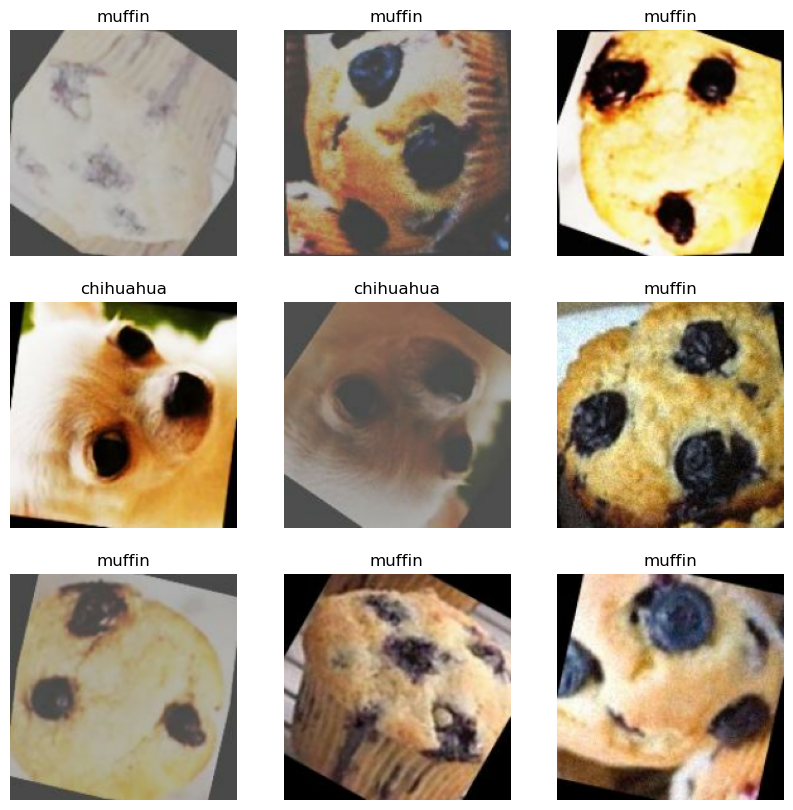

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in dtrain.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
classes=len(class_names)
opt=tf.keras.optimizers.Adam(0.001)
model=tf.keras.models.Sequential()
model.add(layers.Rescaling(1./255,input_shape=(img_height, img_width, 3)))
model.add(layers.RandomFlip("horizontal",input_shape=(img_height, img_width, 3)))
model.add(layers.RandomRotation(0.1))
model.add(layers.RandomZoom(0.1))
model.add(layers.Conv2D(16,3,padding="same",activation="relu"))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(32,3,padding="same",activation="relu"))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(64,3,padding="same",activation="relu"))
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256,activation="relu"))
model.add(layers.Dense(classes))

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(dtrain,validation_data=dtest,epochs=10)

Epoch 1/10
50/50 [==============================] - 16s 316ms/step - loss: 0.6704 - accuracy: 0.5738 - val_loss: 0.5285 - val_accuracy: 0.7775
Epoch 2/10
50/50 [==============================] - 16s 319ms/step - loss: 0.5289 - accuracy: 0.7387 - val_loss: 0.4400 - val_accuracy: 0.8325
Epoch 3/10
50/50 [==============================] - 19s 372ms/step - loss: 0.4081 - accuracy: 0.8125 - val_loss: 0.4862 - val_accuracy: 0.7375
Epoch 4/10
50/50 [==============================] - 17s 337ms/step - loss: 0.3373 - accuracy: 0.8444 - val_loss: 0.2444 - val_accuracy: 0.9375
Epoch 5/10
50/50 [==============================] - 17s 339ms/step - loss: 0.2693 - accuracy: 0.8906 - val_loss: 0.3010 - val_accuracy: 0.8800
Epoch 6/10
50/50 [==============================] - 17s 343ms/step - loss: 0.2910 - accuracy: 0.8744 - val_loss: 0.2193 - val_accuracy: 0.9375
Epoch 7/10
50/50 [==============================] - 17s 349ms/step - loss: 0.2245 - accuracy: 0.9087 - val_loss: 0.2084 - val_accuracy: 0.9425

This image used to be n/a 
but most likely belongs to muffin 
with a 95.55 percent confidence.


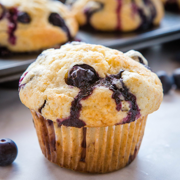

In [7]:
from random import random
#img_paths = glob('./chihuahua-muffin/*/*')
img_paths = glob('../vs/data/dataset/chihuahua-muffin/Test_data/*.jpg')
ind=int(random()*len(img_paths))
img = tf.keras.utils.load_img(
    img_paths[ind], target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image used to be {} \nbut most likely belongs to {} \nwith a {:.2f} percent confidence."
    .format("n/a",class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(img_paths[ind]).resize((180,180))

In [8]:
model.save("../vs/data/model/chihuahua-muffin-classifier.model")

INFO:tensorflow:Assets written to: ../vs/data/model/chihuahua-muffin-classifier.model\assets


In [9]:
model=tf.keras.models.load_model("../vs/data/model/chihuahua-muffin-classifier.model")